# Fusing NV RADIO 2D high-dimensional features into Sparse Voxels

We use the trained `garden` scene from the [example.ipynb](./example.ipynb). The overall fusion pipeline is as follow:
1. Perform voxel pooling.
2. Fusing Vision Foundation Model feature into the pooled voxel.
3. Train a dimension reduction MLP on voxel VFM feature for visualization.

In [1]:
import os
PROJECT_ROOT = os.path.abspath('../')
print("PROJECT_ROOT:", PROJECT_ROOT)

import sys
sys.path.insert(0, PROJECT_ROOT)

import cv2
import time
import numpy as np
from tqdm import tqdm, trange
import imageio
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
from IPython.display import Image, Video

import torch

from src.config import cfg, update_argparser, update_config

from src.dataloader.data_pack import DataPack
from src.sparse_voxel_model import SparseVoxelModel
from src.cameras import MiniCam
from src.utils.image_utils import im_tensor2np, viz_tensordepth
from src.utils.activation_utils import shzero2rgb, rgb2shzero
from src.utils.octree_utils import level_2_vox_size, octpath_decoding, build_grid_pts_link
from src.utils.fuser_utils import Fuser
from src.utils.camera_utils import interpolate_poses

import svraster_cuda

PROJECT_ROOT: /home/chengs/voxworld


In [2]:
OUTPUT_ROOT = os.path.join(PROJECT_ROOT, 'output', 'tutorial')
print("OUTPUT_ROOT:", OUTPUT_ROOT)

DATA_ROOT: /home/chengs/voxworld/data/360_v2/garden
OUTPUT_ROOT: /home/chengs/voxworld/output/tutorial


## Load everything

In [3]:
radio_model = torch.hub.load('NVlabs/RADIO', 'radio_model', version='radio_v2.5-b', progress=True)
radio_model = radio_model.eval().cuda()
for param in radio_model.parameters():
    param.requires_grad = False

radio_patch_size = radio_model.patch_size
radio_dim = radio_model.model.embed_dim
print('radio_dim', radio_dim)

def compute_radio_input_resize(x):
    MAX_RES = 1024
    if x.shape[2] > x.shape[3]:
        target_h = MAX_RES
        target_w = round(MAX_RES * x.shape[3] / x.shape[2])
        target_w = 16 * (target_w // radio_patch_size + (target_w % radio_patch_size != 0))
    else:
        target_w = MAX_RES
        target_h = round(MAX_RES * x.shape[2] / x.shape[3])
        target_h = 16 * (target_h // radio_patch_size + (target_h % radio_patch_size != 0))
    x = torch.nn.functional.interpolate(x, size=(target_h, target_w), mode='bilinear', align_corners=False)
    return x

def compute_radio_feat(x):
    x = x[None] # Add trailing batch dim
    x = x.cuda()
    x = compute_radio_input_resize(x)
    summary, features = radio_model(x, feature_fmt='NCHW')
    return features.squeeze(0)

Using cache found in /home/chengs/.cache/torch/hub/NVlabs_RADIO_main
/home/chengs/miniconda3/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/chengs/miniconda3/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


radio_dim 768


In [4]:
model_path = OUTPUT_ROOT
update_config(os.path.join(model_path, 'config.yaml'))

In [5]:
# Load data
data_pack = DataPack(cfg.data, cfg.model.white_background)
tr_cams = data_pack.get_train_cameras()
te_cams = data_pack.get_test_cameras()

Read dataset in COLMAP format.
images_folder=/home/chengs/voxworld/data/360_v2/garden/images
res_downscale=0.0
res_width=0
[WARN] Source images are too large (5187x3361). 
       Auto downscale gt by 4.077485483823158. 
       Use `--images`, `--res_downscale`, or `--res_width` to prevent it.


In [6]:
# Load model
voxel_model = SparseVoxelModel(cfg.model)
loaded_iter = voxel_model.load_iteration()
ori_sh0 = voxel_model.sh0.data.clone()
ori_shs = voxel_model.shs.data.clone()

## Fusing 2D VFM feature

In [7]:
with torch.no_grad():
    
    # Compute voxel pooling
    pooling_pack = voxel_model.pooling_to_rate(tr_cams, max_rate=3.0)
    # pooling_pack = voxel_model.pooling_to_level(max_level=13)
    vox_center = pooling_pack['vox_center']
    invmap = pooling_pack['invmap']
    print(f"Voxel pooling: {voxel_model.num_voxels} => {len(vox_center)}")
    
    # Define volume integrator
    finest_vox_size = level_2_vox_size(voxel_model.scene_extent, voxel_model.octlevel.max()).item()
    feat_volume = Fuser(
            xyz=vox_center,
            bandwidth=50 * finest_vox_size,
            use_trunc=False,
            fuse_tsdf=False,
            feat_dim=radio_dim,
            crop_border=0.,
            normal_weight=False,
            depth_weight=False,
            border_weight=False,
            use_half=True)

    # Run feature fusion
    for cam in tqdm(tr_cams):
        patch_emb = compute_radio_feat(cam.image)
        patch_emb = torch.nn.functional.normalize(patch_emb, dim=0)
        
        render_pkg = voxel_model.render(cam, output_depth=True, output_T=True)
        depth = render_pkg['depth'][0] / (1 - render_pkg['T'][0]).clamp_min(1e-6)
        feat_volume.integrate(cam=cam, feat=patch_emb, depth=depth)

        # Cleanup
        del patch_emb, depth, render_pkg
        torch.cuda.empty_cache()


# Get the final feature and cleanup
torch.cuda.empty_cache()
feature = feat_volume.feature.nan_to_num_()

del feat_volume
torch.cuda.empty_cache()

Voxel pooling: 9457214 => 2420592


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:26<00:00,  6.18it/s]


## Voxel feature dimension reduction for visualization

In [8]:
n_iters = 1000
batch_size = min(len(feature), 200_000)

latent_encoder = torch.nn.Sequential(
    torch.nn.Linear(radio_dim, radio_dim//2),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(radio_dim//2, radio_dim//4),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(radio_dim//4, 3),
    torch.nn.Sigmoid(),
).cuda()

latent_decoder = torch.nn.Sequential(
    torch.nn.Linear(3, radio_dim//4),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(radio_dim//4, radio_dim//2),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(radio_dim//2, radio_dim),
).cuda()

optim = torch.optim.Adam([
    {'params': latent_encoder.parameters()},
    {'params': latent_decoder.parameters()},
], lr=1e-3, eps=1e-15)

for i_it, cam_id in enumerate(np.random.randint(0, len(tr_cams), n_iters), 1):
    with torch.no_grad():
        emb = feature[torch.randint(0, len(feature), [batch_size])].float()
    with torch.enable_grad():
        code = latent_encoder(emb)
        pred = latent_decoder(code)
        loss = torch.nn.functional.smooth_l1_loss(pred, emb)
    loss.backward()
    optim.step()
    optim.zero_grad(set_to_none=True)
    if i_it == round(n_iters * 0.9):
        for param_group in optim.param_groups:
            param_group["lr"] *= 0.1
    if i_it % 200 == 0 or i_it < 10:
        print(f"iter={i_it}: loss={loss:.6f}")

# Convert type
latent_encoder = latent_encoder.to(feature.dtype)
latent_decoder = latent_decoder.to(feature.dtype)

# Clean up
del optim, emb, code, pred, loss
torch.cuda.empty_cache()

iter=1: loss=0.003342
iter=2: loss=0.001575
iter=3: loss=0.000835
iter=4: loss=0.000553
iter=5: loss=0.000449
iter=6: loss=0.000405
iter=7: loss=0.000375
iter=8: loss=0.000350
iter=9: loss=0.000331
iter=200: loss=0.000094
iter=400: loss=0.000073
iter=600: loss=0.000064
iter=800: loss=0.000059
iter=1000: loss=0.000056


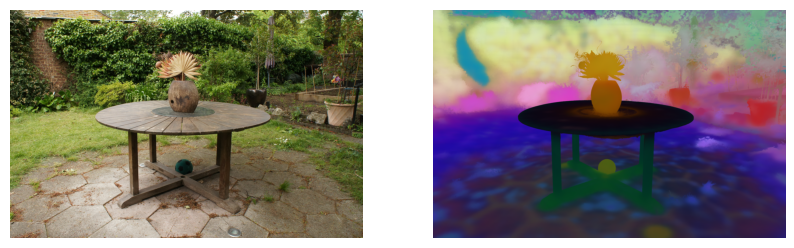

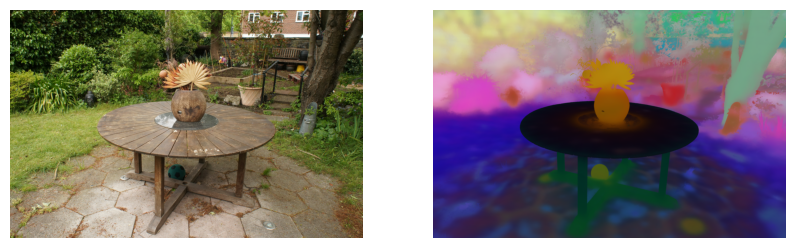

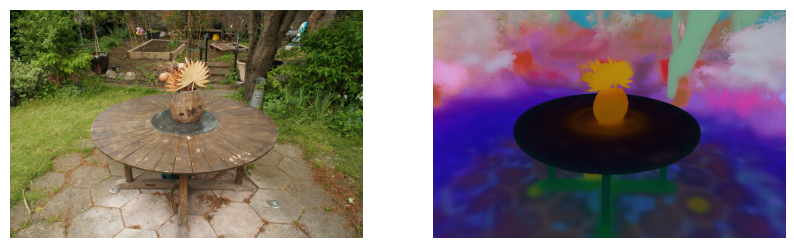

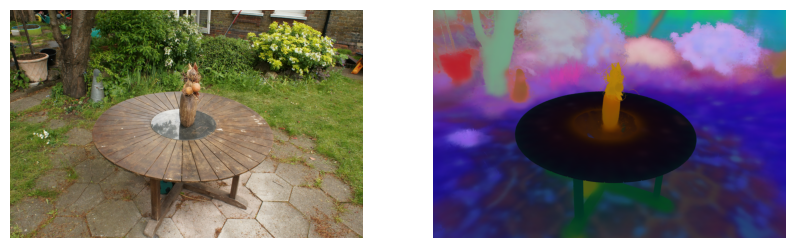

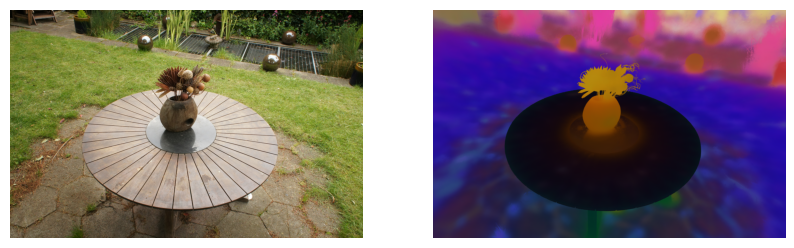

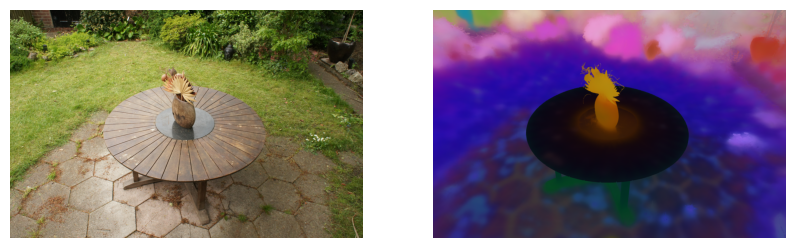

In [9]:
with torch.no_grad():
    code = latent_encoder(feature)
    viz_color = code[invmap]
    del code
    torch.cuda.empty_cache()

voxel_model.sh0.data[:] = rgb2shzero(viz_color)
voxel_model.shs.data[:] = 0

with torch.no_grad():
    for cam in tr_cams[::len(tr_cams)//5]:

        render_clscolor = voxel_model.render(cam)['color']
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
        ax[0].imshow(im_tensor2np(cam.image))
        ax[1].imshow(im_tensor2np(render_clscolor))
        ax[0].axis('off')
        ax[1].axis('off')
        plt.show()

## Render fly-through video

In [10]:
key_frame_ids = [] # Set to empty list to enable farthest point sampling
periodic = True
n_frames = 300

fovx = tr_cams[0].fovx
fovy = tr_cams[0].fovy
width = round(tr_cams[0].image_width * 1.0)
height = round(tr_cams[0].image_height * 1.0)
near = tr_cams[0].near

In [11]:
# Use farthest point sampling
if len(key_frame_ids) == 0:
    cam_pos = torch.stack([cam.position for cam in tr_cams])
    key_frame_ids = [0]
    for _ in range(3):
        farthest_id = torch.cdist(cam_pos[key_frame_ids], cam_pos).amin(0).argmax().item()
        key_frame_ids.append(farthest_id)
    key_frame_ids[1], key_frame_ids[2] = key_frame_ids[2], key_frame_ids[1]
    key_poses = [tr_cams[i].c2w.cpu().numpy() for i in key_frame_ids]

key_poses = [tr_cams[i].c2w.cpu().numpy() for i in key_frame_ids]
interp_poses = interpolate_poses(key_poses, n_frame=n_frames, periodic=periodic)

interp_cams = [
    MiniCam(
        c2w=pose,
        fovx=fovx, fovy=fovy,
        width=width, height=height,
        near=near)
    for pose in interp_poses
]

In [12]:
outroot = 'demos_radio'
scene_name = os.path.split(voxel_model.model_path)[1]
os.makedirs(outroot, exist_ok=True)

with torch.no_grad():

    voxel_model.sh0.data[:] = ori_sh0
    voxel_model.shs.data[:] = ori_shs
    video = [
        im_tensor2np(voxel_model.render(cam)['color'])
        for cam in tqdm(interp_cams)
    ]
    imageio.mimwrite(f"{outroot}/{scene_name}_rgb.mp4", video, quality=8, fps=30)

    voxel_model.sh0.data[:] = rgb2shzero(viz_color)
    voxel_model.shs.data[:] = 0
    video = [
        im_tensor2np(voxel_model.render(cam)['color'])
        for cam in tqdm(interp_cams)
    ]
    imageio.mimwrite(f"{outroot}/{scene_name}_A.mp4", video, quality=8, fps=30)

    voxel_model.sh0.data[:] = ori_sh0
    voxel_model.shs.data[:] = ori_shs
    video = []
    for cam in tqdm(interp_cams):
        im = voxel_model.render(cam)['color']
        patch_emb = compute_radio_feat(im)
        patch_emb = torch.nn.functional.normalize(patch_emb, dim=0)
        patch_emb = patch_emb.moveaxis(0, -1)
        code = latent_encoder(patch_emb.to(feature.dtype))
        code = code.moveaxis(-1, 0)
        code = torch.nn.functional.interpolate(
            code[None],
            size=(cam.image_height, cam.image_width),
            mode='nearest')[0]
        video.append(im_tensor2np(code))
    imageio.mimwrite(f"{outroot}/{scene_name}_B.mp4", video, quality=8, fps=30)

# Composite all videos
v0 = cv2.VideoCapture(f"{outroot}/{scene_name}_rgb.mp4")
v1 = cv2.VideoCapture(f"{outroot}/{scene_name}_A.mp4")
v2 = cv2.VideoCapture(f"{outroot}/{scene_name}_B.mp4")
video = []
for i in trange(n_frames):
    ret, f0 = v0.read()
    ret, f1 = v1.read()
    ret, f2 = v2.read()
    im = np.concatenate([f0, f1, f2], axis=1)[..., ::-1]
    video.append(im)

imageio.mimwrite(f"{outroot}/{scene_name}.mp4", video, fps=30)
Video(f"{outroot}/{scene_name}.mp4", width=1024)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 88.29it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1272, 824) to (1280, 832) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5923240] Warning: data is not aligned! This can lead to a speed loss
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 85.75it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1272, 824) to (1280, 832) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_si